In [4]:
import torch
import matplotlib.pyplot as plt

In [5]:
from model import UNET
from torchinfo import summary
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model, model_name = UNET(), "UNET_caranvas.pth"
path = os.path.join('models', model_name)
model.load_state_dict(torch.load(path, weights_only=True))
model.to(device)
model.eval()
summary(model, input_size=(8, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
UNET                                     [8, 1, 256, 256]          --
├─ModuleList: 1-1                        --                        --
│    └─DoubleConv: 2-1                   [8, 64, 256, 256]         --
│    │    └─Sequential: 3-1              [8, 64, 256, 256]         38,976
│    └─DoubleConv: 2-2                   [8, 128, 128, 128]        --
│    │    └─Sequential: 3-2              [8, 128, 128, 128]        221,952
│    └─DoubleConv: 2-3                   [8, 256, 64, 64]          --
│    │    └─Sequential: 3-3              [8, 256, 64, 64]          886,272
│    └─DoubleConv: 2-4                   [8, 512, 32, 32]          --
│    │    └─Sequential: 3-4              [8, 512, 32, 32]          3,542,016
├─DoubleConv: 1-2                        [8, 1024, 16, 16]         --
│    └─Sequential: 2-5                   [8, 1024, 16, 16]         --
│    │    └─Conv2d: 3-5                  [8, 1024, 16, 16]      

In [6]:
from utils.transforms import get_train_transforms
from torch.utils.data import DataLoader
from dataset import CarvanaDataset

dataset = CarvanaDataset('data', True, transforms=get_train_transforms())
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
imgs, masks = next(iter(dataloader))
imgs, masks = imgs.to(device), masks.to(device)

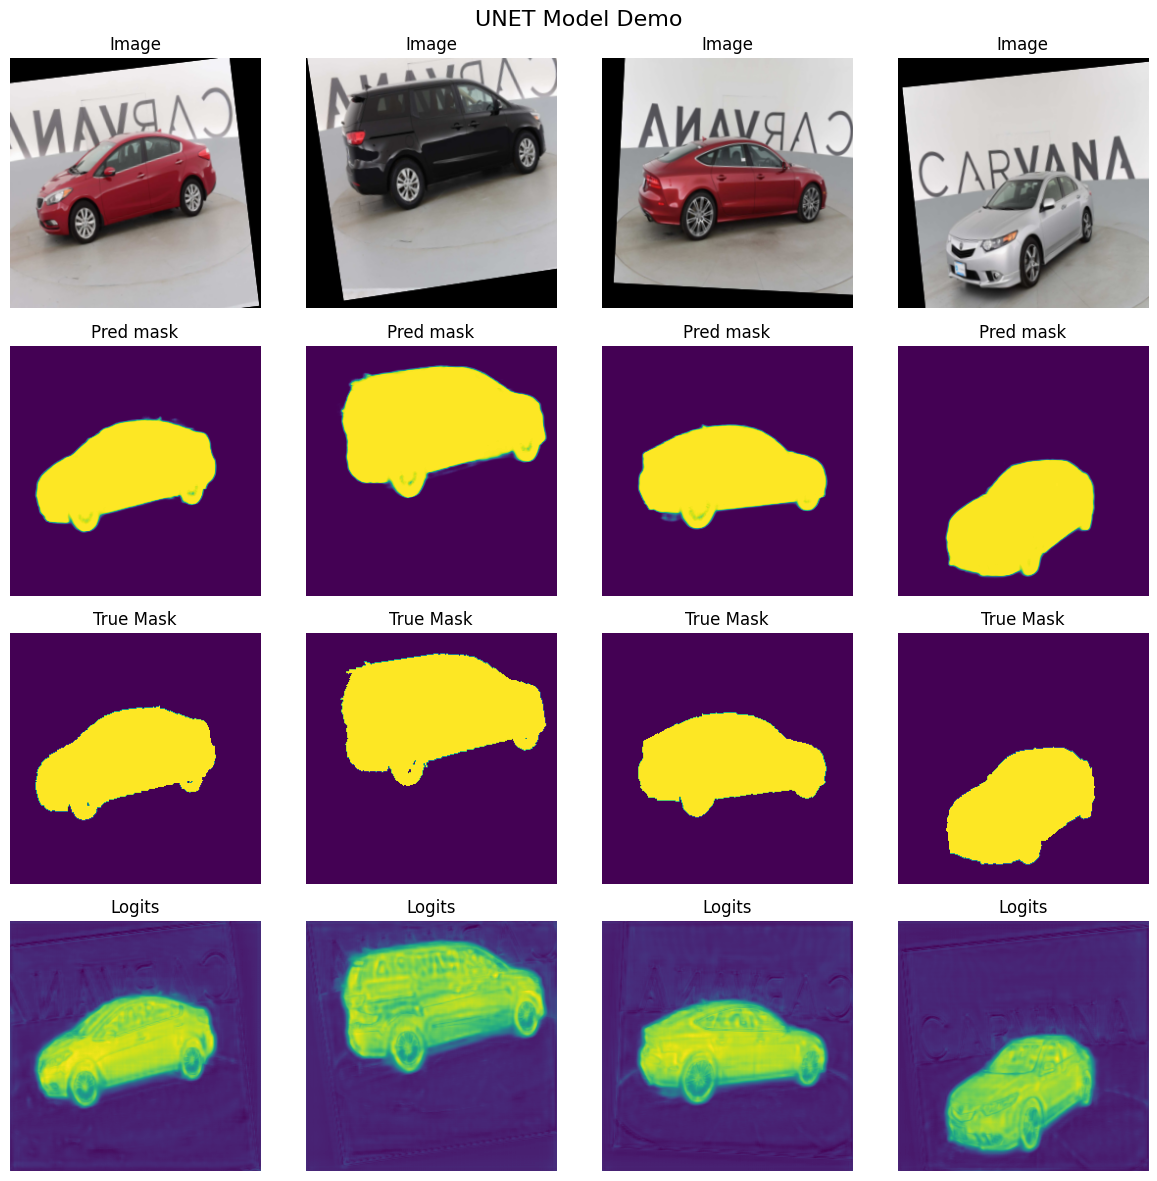

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

fig.suptitle('UNET Model Demo', fontsize=16)

for i in range(4):
    pred_dict = model.predict(imgs[i].unsqueeze(0))    
    pred = pred_dict['pred']
    img = pred_dict['img']
    logits = pred_dict['logits']
    true_mask = masks[i].cpu().numpy().transpose(1, 2, 0)
    
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title('Image')
    
    axs[1, i].imshow(pred)
    axs[1, i].axis('off')
    axs[1, i].set_title('Pred mask')
    
    axs[2, i].imshow(true_mask)
    axs[2, i].axis('off')
    axs[2, i].set_title('True Mask')
    
    axs[3, i].imshow(logits)
    axs[3, i].axis('off')
    axs[3, i].set_title('Logits')
    
plt.tight_layout()
plt.show()
